# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Instantiate a rendering and a non-rendering environment.
env_render = gym.make('CartPole-v1', render_mode='human')
env = gym.make('CartPole-v1')

CartPole è un carrello che può muoversi a sinistra o a destra su un binario, sopra il carello è montato un pali collegato con una cerniera alla base, l'agente deve bilanciare il palo muovendo il carello 
Stati (osservazioni):
1) posizione del carello
2) velocità del carello 
3) angolo del palo
4) velocità angolare del palo 

Azioni: 
0) spinge il carello a sinistra
1) spinge il carello a destra

Ricompensa:
Se il palo rimane in piedi allora avro una reward +1

Condizioni di fine episodio
1) angolo troppo grande: Il palo cade
2) carello esce dai limiti di pista
3) si supera 500 passi

Obbiettivo: imaprare una politica che muova il carello in modo da non far cadere il palo il più a lungo possibile

In [2]:
obs, info= env.reset()

print(f'Observation after the reset: {obs}')
print(f'information of action {info}')

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)


Observation after the reset: [ 0.0149404  -0.0409965  -0.01206485 -0.03211079]
information of action {}
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


observation space: [posizione carello, velocità carello, angolo del palo, velocità angolare del palo]
action space: (discreto) [0 sposta a sinistra, 1 sposta a destra]

**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

In [2]:
import numpy as np
import gymnasium as gym
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
from reinforce_cartpole import PolicyNetwork, ReinforceAgent, TrainAgentRenforce
import pygame
_ = pygame.init()

now= datetime.datetime.now()
data_ora_formattata = now.strftime("%d_%m_%yT%H_%M")
name= f'run_{data_ora_formattata}'

#env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("CartPole-v1")
pygame.display.init() 
name_agent="CartPole_REINFORCE"
temperature_train=0.7
general_path= f'Reinforcment_Learning/{name_agent}_{data_ora_formattata}_temp_{temperature_train}'

checkpoint_path=general_path+"/checkpoint"
bestmodel_path= general_path+"/best_model"
hyperparamtres_path= general_path+"/hyperparametres"

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = PolicyNetwork(obs_dim=obs_dim, action_dim=action_dim)

logdir= f'tensorboard/Reinforcment_Learning/{name_agent}/{name}_temp_{temperature_train}'

agent = ReinforceAgent(
    enviroment=env,
    logdir=logdir, 
    policy=policy,
    gamma=0.99,
    max_lenght=500
)

trainer = TrainAgentRenforce(
    reinforcagent=agent,
    lr=1e-2,
    num_episode=500,
    num_episode_validation=10,
    check_val=10,
    checkpoint_path=checkpoint_path,
    best_model_path=bestmodel_path,
    hyperparams_path=hyperparamtres_path,
    temperature_train=temperature_train
)

try:
    running_rewards = trainer.train_agent()
finally:
    env.close()
    pygame.display.quit()
    pygame.quit()


pygame.display.quit()


Checkpoint not founded, start a new Training


Running reward train from episode 10: 14.0
Average reward test from episode 10: 9.2

Running reward train from episode 20: 15.0
Average reward test from episode 20: 24.4

Running reward train from episode 30: 28.0
Average reward test from episode 30: 47.3

Running reward train from episode 40: 47.0
Average reward test from episode 40: 102.9



Process Process-2:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data01/dl24natacc/Deep_Learning_Application/Homework_2/stats_windows.py", line 57, in run_stats_window
    time.sleep(0.1)
KeyboardInterrupt


KeyboardInterrupt: 

## Risultati
Dal codice di partenza fornito è stato pulito e diviso in varie componenti in modo tale da avere una maggiore generalizzazione delle classi.
Successivamente sono state introdotte varie componenti aggiuntive:
1) Un parametro di temperatura che sostanzialmente serve per il campionamento dalla distribuzione di probabilità nella scelta delle azioni.
Più la temperatura è grande e più la distribuzione diventa uniforme e quindi si ha più esplorazione da parte del modello, al contrario più la temperatura è piccola più il modello sceglie azioni deterministiche selezionando sempre quella migliore
2) introduzione di varie metriche: 
    1) Lunghezza dell' episodio: Serve per misurare le performance e la stabilità del modello, infatti è gradevole avere un modello che dopo t iterazioni ha episodi più lunghi fino ad completarli.
    2) Deviazione standard: Valuta la stabilità del modello, se risulta alta oppure altalenante vuol dire che il modello non è del tutto stabile, mentre quando si ha una deviazione standard che tende a diminuire significa che il modello tende a prendere le stesse decisioni.
    3) Min reward: misura la ricompensa minima che si ha nell' episodio, è un ottimo metodo per capire se il modello risulta essere stabile e efficiente all' interno dell' ambiente infatti una volta che il modello impara ci si aspetta una min reward sempre più alta.
    4) max reward: Misura l'efficienza del modello, infatti serve a dare una stima della ricompensa massima ottenuta dal modello 
    5) mean reward: Misura la ricompensa media anche questo da sintomi di stabilità o instabilità infatti, la cosa che ci aspettiamo è che essa salga poichè significherebbe che il modello mediamente compiè azioni che hanno un alta ricompensa.
    6) termination failure/success: Rappresentano il numero di successi/fallimenti all' interno dell' addestramento, questo ci da una misura di quanto il modello poi riesca o meno a portare a termine l'obbiettivo
    7) percentile 10%: serve per valutare gli episodi peggiori che stanno sotto al 10%. ci da una misura di quanto il modello durante l'addestramento riesca a migliorarsi quindi a portare il 10% degli episodi peggiori comunque a delle ottime metriche.

Sono stati fatti vari addestramenti cercando di andare a modificare la temperatura e non introducendo alcuna baseline (essendo esercizio successivo).
Il range di temperatura preso è stato:
1: distribuzione morbida equilibrata tra determinismo e stocasticità 
2: distribuzione quasi uniforme molto piatta quindi qausi solamente esplorazione
0.3-0.5-0.7: distribuzione più deterministica il modello si concentra sul' prendere azioni migliori, poca esplorazione

Il risultato ottenuto è che la temperatura a 0.5 risulti essere effettivamente la migliore anche se porta con se una certa instabilità che si riscontra sia nella reward sia nella deviazione standard. ma comunque è l'unica che riesce a ottenere i risultati migliori

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

In [1]:
#import numpy as np
#import gymnasium as gym
#import torch 
#import torch.nn as nn
#import torch.optim as optim
#from torch.distributions import Categorical
#import torch.nn.functional as F
#import matplotlib.pyplot as plt
#from torch.utils.tensorboard import SummaryWriter
#import os
#import datetime
#from reinforce_cartpole import PolicyNetwork, ReinforceAgent, TrainAgentRenforce
##import pygame
##_ = pygame.init()
#
#now= datetime.datetime.now()
#data_ora_formattata = now.strftime("%d_%m_%yT%H_%M")
#name= f'run_{data_ora_formattata}'
#
##env = gym.make("CartPole-v1", render_mode="human")
#env = gym.make("CartPole-v1")
##pygame.display.init() 
#name_agent="CartPole_REINFORCE"
#normalizzation_discount=False
#baseline_discount=False
#temperature_train=[0.3, 0.5, 0.7, 1 , 1.5, 2]
#for temp in temperature_train:
#    for subtract in [True,False]:
#        baseline= "simple_subtract" if subtract else "normalization"
#
#
#        general_path= f'Reinforcment_Learning_Classic_Baseline_sub_std/{name_agent}_{data_ora_formattata}_temp_{temp}_Baseline_{baseline}'
#
#        checkpoint_path=general_path+"/checkpoint"
#        bestmodel_path= general_path+"/best_model"
#        hyperparamtres_path= general_path+"/hyperparametres"
#
#        obs_dim = env.observation_space.shape[0]
#        action_dim = env.action_space.n
#
#        policy = PolicyNetwork(obs_dim=obs_dim, action_dim=action_dim)
#
#        logdir= f'tensorboard/Reinforcment_Learning_Baseline_sub_std/{name_agent}/{name}_temp_{temp}_BaseLine_{baseline}'
#
#        agent = ReinforceAgent(
#            enviroment=env,
#            logdir=logdir, #da modificare
#            policy=policy,
#            gamma=0.99,
#            max_lenght=500
#        )
#
#        trainer = TrainAgentRenforce(
#            reinforcagent=agent,
#            lr=1e-2,
#            num_episode=500,
#            num_episode_validation=10,
#            check_val=10,
#            checkpoint_path=checkpoint_path,
#            best_model_path=bestmodel_path,
#            hyperparams_path=hyperparamtres_path,
#            temperature_train=temp
#        )
#        if baseline:
#            running_rewards = trainer.train_agent(normalizzation_discount=False,baseline_discount_sub=True)
#        else:
#            running_rewards=trainer.train_agent(normalizzation_discount=True,baseline_discount_sub=False)

## Risultati
In questa parte di codice viene implementata la differenza tra due tipi di baseline:
1) Baseline base dove si sottrae ai ritorni la media di essi.
2) Baseline con standardizzazione dove si applica media e varianza dei ritorni.


Questa tecniche servono per la stabilizzazione dei gradietni e dunque ad avere un allenamento più fluido e un modello più stabile.
Queste due tecniche sonoi state trainate con lo stesso range di temperature viste sopra e il risultato ci mostra che non vi è un solo modello che mostra valore migliore.
Si parte con la premessa che dagli esperimenti fatti si nota che la baseline che adotta la normalizzazione riesce ad avere dei gradienti più stabili e diciamo migliori performance in generale.
Ci focalizziamo sopratutto su 4 modelli:
1) temp_0.3_BaseLine_normalization
2) temp_0.5_BaseLine_simple_subtract
3) temp_0.7_BaseLine_normalization
4) temp_0.7_BaseLine_simple_subtract

Possiamo vedere questi risultati nel loro complesso dove la situazione risulta anche diciamo essere un po strana.
Infatti si può vedere come i primi due modelli in Training riportino delle metriche migliori rispetto a gli ultimi due, anche se la situazione non è analoga per la validazione dove si ha quasi la situazione opposta.
Quello che si può tirar fuori dalle metriche che si vedono e l'estrazione di due modelli migliori.
Infatti si può vedere come due modelli spiccano tra tutti il resto che sono:
1) temp_0.3_BaseLine_normalization
2) temp_0.5_BaseLine_simple_subtract

Infatti si può vedere come il loro comportamento risulti abbastanza analogo nei plot delle varie metriche, anche se in termini di stabilità sicuramente risulta esserlo maggiormente il 1 modello essendo che comunica attraverso i grafici una stabilità maggiore sia perchè dopo l'epoca 230 la deviazione standard risulta essere verametnte bassa, e le metriche in generale tendono a esseere molto stabili.
Un' altra piccola differenza di stabilità si vede anche nei grafici di train sia per quanto riguarda la loss sia per quanto riguarda la reward media e ovviamenete dato anche dal maggior numero di successi.






**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

In [1]:
#import numpy as np
#import gymnasium as gym
#import torch 
#import torch.nn as nn
#import torch.optim as optim
#from torch.distributions import Categorical
#import torch.nn.functional as F
#import matplotlib.pyplot as plt
#from torch.utils.tensorboard import SummaryWriter
#import os
#import datetime
#from reinforce_cartpole import PolicyNetwork, ReinforceAgent, TrainAgentRenforce
##import pygame
##_ = pygame.init()
#
#nv = gym.make("CartPole-v1")
##pygame.display.init() 
#name_agent="CartPole_REINFORCE"
#normalizzation_discount=False
#baseline_discount=False
#temperature_train=[0.3, 0.5, 0.7, 1 , 1.5, 2]
#lr_value_net= [1e-2,1e-3,1e-4]
#for temp in temperature_train:
#    for lr_vnet in lr_value_net:
#        now= datetime.datetime.now()
#        data_ora_formattata = now.strftime("%d_%m_%yT%H_%M")
#        name= f'run_{data_ora_formattata}'
#        general_path= f'Reinforcment_Learning_Value_Net/{name_agent}_{data_ora_formattata}_temp_{temp}'
#
#        checkpoint_path=general_path+"/checkpoint"
#        bestmodel_path= general_path+"/best_model"
#        hyperparamtres_path= general_path+"/hyperparametres"
#
#        obs_dim = env.observation_space.shape[0]
#        action_dim = env.action_space.n
#
#        policy = PolicyNetwork(obs_dim=obs_dim, action_dim=action_dim)
#
#        logdir= f'tensorboard/Reinforcment_Learning_Value_Net/{name_agent}/{name}_temp_{temp}'
#
#        agent = ReinforceAgent(
#            enviroment=env,
#            logdir=logdir, 
#            policy=policy,
#            gamma=0.99,
#            max_lenght=500,
#            value_net=True
#        )
#
#        trainer = TrainAgentRenforce(
#            reinforcagent=agent,
#            lr=1e-2,
#            num_episode=500,
#            num_episode_validation=10,
#            check_val=10,
#            checkpoint_path=checkpoint_path,
#            best_model_path=bestmodel_path,
#            hyperparams_path=hyperparamtres_path,
#            temperature_train=temp,
#            lr_value_net=lr_vnet
#        )
#        running_rewards = trainer.train_agent()
#

## Risultati
L'implementazione della rete neurale per stimare la baseline, quindi per la valutazione del ritorno atteso rispetto allo stato che ci troviamo, è eseguita attraverso una rete molto simile a quella della policy con qualche piccola differenza. Infatti nella rete in questione l'output finale è un vettore che rappresetna il valore dei ritorni.
Questa tecnica serve proprio a stimare i guadagni attesi rispetto allo stato in cui ci troviamo e differentemente dai metodi precedenti non dipendono dall' azione ma solo stato o dai ritorni che si ottiene, per questo possono risultare poco efficienti.
In questo script dunque viene aggiunta la rete per valutare i ritorni e viene utilizzata come baseline durante l'addestramneto del modello. 
dove con il blocco:
returns = self.compute_discount_returns(rewards)        
values = self.value_net(torch.stack(observations)).squeeze() 
advantages = returns - values.detach() 
Viene proprio caclolato 
$$ G_t - \tilde v(S_t|w) $$

Questa nuova versione è stata testata mantenendo il learning rate della policy fisso essendosi rivelato giusto per l' esercizio precedente, mentre vengono variate:
1) Learning rate della value net: $[1e-2,1e-3,1e-4]$
2) temperatura per la natura della policy: $ [0.3, 0.5, 0.7, 1 , 1.5, 2]$

La temperatura è stata mantenuta nel range corrente , anche se come visto in precedenza per il particolare problema la troppa stocasticità sicuramente non porta dei vantaggi.
Però è stato testato tutto il range per verificare che effettivamente anche in questo caso la temperatura ricadesse nei valori visti in precedenza.
I risultati che saltano più all' occhio in questo esperimento sicuramente sono:
- Reinforcment_Learning_Value_Net/CartPole_REINFORCE_22_10_25T09_49_temp_0.3
- Reinforcment_Learning_Value_Net/CartPole_REINFORCE_22_10_25T09_50_temp_0.5

I quali mostrano un ottimo comportamento delle due reti e delle metriche fin ora descritte.
In aggiunta mostrano anche dei risultati migliori rispetto agli altri modelli per quanto riguarda le nuove metriche inserite per valutare anche la value network.
Infatti vi sono state aggiunte:
1) MSE (Mean Sqaure Error): È la media del quadrato dell’errore di predizione tra i ritorni reali e quelli stimati dalla rete.Penalizza molto gli errori grandi, che rappresenta anche la LOSS della nuova rete.
2) MAE (Mean Absolute Error):È la media dell’errore assoluto tra la predizione e il ritorno reale.
Penalizza gli errori in modo lineare.

Anche se i risultati possono assumere valori molto grandi, risultano essere commisurati ai tipi di ritorni che abbiamo e quindi del tutto normali essendo proprio che la scala di essi va da 0 a 500.
Si nota anche come i due modelli differiscano poco nelle varie metriche. 
L'unica differenza sembra essere che il 1° modello sia più regolare e stabile infatti ha una crescita stabile e anche la deviazione standard risulta avere un' andamento migliore, anche se il 2° possiamo dire che arriva prima a convergenza e quindi ad avere un comportamento migliore anche se risulta essere diciamo più instabile in termini di deviazioni standard e di loss.
Una nota da poter vedere è come entrambi i migliori abbiano il medesimo learing rate per la value net che è di $1e-2$


-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 

## Esercizio 2
Si utilizza il Q-learning 

In [ ]:
import numpy as np
import gymnasium as gym
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import os
import datetime
import Q_Learining as QL
import config

#_ = pygame.init()

path_base="Reinforcement_Learning_CartLunar"
logdir= f"tensorboard/{path_base}"
device= "cuda" if torch.cuda.is_available() else "cpu"
for key,value in config.Config.items():
    if value["env_id"]=="CartPole-v1":
        continue
    agent_name= key
    if value["human"]==False:
        env= gym.make(value["env_id"])
        env_validation= gym.make(value["env_id"])
    else:
        env= gym.make(value["env_id"], render_mode="human")
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    replay_buffer= QL.ReplayBuffer(value["replay_buffer_size"],obs_dim,device)
    now= datetime.datetime.now()
    data_ora_formattata = now.strftime("%d_%m_%yT%H_%M")
    name= f'run_{data_ora_formattata}'
    path= f"{path_base}/{agent_name}/{name}"
    logdir_exp= f"{logdir}/{agent_name}/{name}"
    writer= SummaryWriter(logdir_exp)
    print(f"Train Agent {agent_name}")
    agent= QL.DQNAgent(obs_dim,
                       action_dim,
                       replay_buffer,
                       writer,
                       device,
                       path,
                       value["hidden_size"],
                       batch_size=value["batch_size"],
                       target_update_freq=value["target_update_freq"],
                       epsilon_decay=value["epsilon_decay"],
                       epsilon_end=value["epsilon_end"]
                       )
    
    #agent.train(env,env_validation,value["num_episode_train"],value["num_episode_validation"])


 Caricamento del mododello per test su CartPole-v1

 Modello caricato correttamente 

Avvio test


Testing:   2%|▏         | 1/50 [00:00<00:05,  9.32it/s]

Episodio 01 → Reward 500.0


Testing:   6%|▌         | 3/50 [00:00<00:04, 11.61it/s]

Episodio 02 → Reward 500.0
Episodio 03 → Reward 500.0


Testing:   6%|▌         | 3/50 [00:00<00:04, 11.61it/s]

Episodio 04 → Reward 500.0


Testing:  10%|█         | 5/50 [00:00<00:03, 11.74it/s]

Episodio 05 → Reward 500.0
Episodio 06 → Reward 500.0


Testing:  14%|█▍        | 7/50 [00:00<00:03, 12.36it/s]

Episodio 07 → Reward 500.0


Testing:  18%|█▊        | 9/50 [00:00<00:03, 12.91it/s]

Episodio 08 → Reward 500.0
Episodio 09 → Reward 500.0


Testing:  18%|█▊        | 9/50 [00:00<00:03, 12.91it/s]

Episodio 10 → Reward 500.0


Testing:  22%|██▏       | 11/50 [00:00<00:02, 13.18it/s]

Episodio 11 → Reward 500.0
Episodio 12 → Reward 500.0


Testing:  26%|██▌       | 13/50 [00:01<00:02, 13.33it/s]

Episodio 13 → Reward 500.0


Testing:  30%|███       | 15/50 [00:01<00:02, 13.59it/s]

Episodio 14 → Reward 500.0
Episodio 15 → Reward 500.0


Testing:  30%|███       | 15/50 [00:01<00:02, 13.59it/s]

Episodio 16 → Reward 500.0


Testing:  34%|███▍      | 17/50 [00:01<00:02, 13.49it/s]

Episodio 17 → Reward 500.0
Episodio 18 → Reward 500.0


Testing:  38%|███▊      | 19/50 [00:01<00:02, 13.58it/s]

Episodio 19 → Reward 500.0


Testing:  42%|████▏     | 21/50 [00:01<00:02, 13.53it/s]

Episodio 20 → Reward 500.0
Episodio 21 → Reward 500.0


Testing:  42%|████▏     | 21/50 [00:01<00:02, 13.53it/s]

Episodio 22 → Reward 500.0


Testing:  46%|████▌     | 23/50 [00:01<00:01, 13.55it/s]

Episodio 23 → Reward 500.0
Episodio 24 → Reward 500.0


Testing:  50%|█████     | 25/50 [00:01<00:01, 13.38it/s]

Episodio 25 → Reward 500.0


Testing:  54%|█████▍    | 27/50 [00:02<00:01, 13.45it/s]

Episodio 26 → Reward 500.0
Episodio 27 → Reward 500.0


Testing:  54%|█████▍    | 27/50 [00:02<00:01, 13.45it/s]

Episodio 28 → Reward 500.0


Testing:  58%|█████▊    | 29/50 [00:02<00:01, 13.47it/s]

Episodio 29 → Reward 500.0
Episodio 30 → Reward 500.0


Testing:  62%|██████▏   | 31/50 [00:02<00:01, 13.46it/s]

Episodio 31 → Reward 500.0


Testing:  66%|██████▌   | 33/50 [00:02<00:01, 13.46it/s]

Episodio 32 → Reward 500.0
Episodio 33 → Reward 500.0


Testing:  66%|██████▌   | 33/50 [00:02<00:01, 13.46it/s]

Episodio 34 → Reward 500.0


Testing:  70%|███████   | 35/50 [00:02<00:01, 13.53it/s]

Episodio 35 → Reward 500.0
Episodio 36 → Reward 500.0


Testing:  74%|███████▍  | 37/50 [00:02<00:00, 13.54it/s]

Episodio 37 → Reward 500.0


Testing:  78%|███████▊  | 39/50 [00:02<00:00, 13.49it/s]

Episodio 38 → Reward 500.0
Episodio 39 → Reward 500.0


Testing:  78%|███████▊  | 39/50 [00:03<00:00, 13.49it/s]

Episodio 40 → Reward 500.0


Testing:  82%|████████▏ | 41/50 [00:03<00:00, 13.49it/s]

Episodio 41 → Reward 500.0
Episodio 42 → Reward 500.0


Testing:  86%|████████▌ | 43/50 [00:03<00:00, 13.56it/s]

Episodio 43 → Reward 500.0


Testing:  90%|█████████ | 45/50 [00:03<00:00, 13.15it/s]

Episodio 44 → Reward 500.0
Episodio 45 → Reward 500.0


Testing:  90%|█████████ | 45/50 [00:03<00:00, 13.15it/s]

Episodio 46 → Reward 500.0


Testing:  94%|█████████▍| 47/50 [00:03<00:00, 13.17it/s]

Episodio 47 → Reward 500.0
Episodio 48 → Reward 500.0


Testing:  98%|█████████▊| 49/50 [00:03<00:00, 13.35it/s]

Episodio 49 → Reward 500.0


Testing: 100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


Episodio 50 → Reward 500.0

 RISULTATI FINALI
   Reward medio: 500.00 ± 0.00
   Reward max : 500.0
   Reward min : 500.0
   Steps medi : 500.0


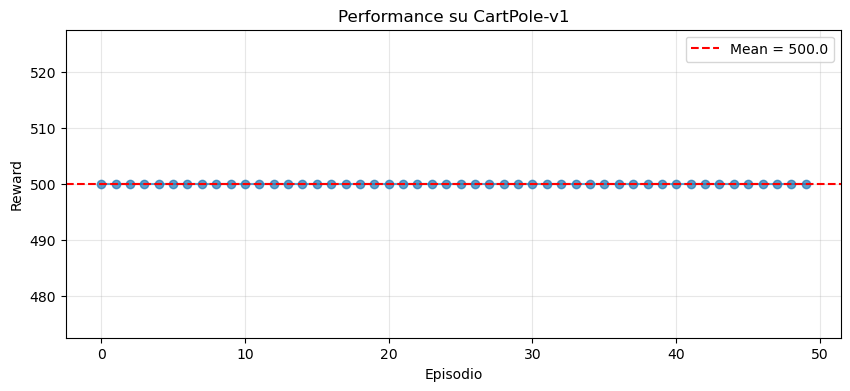


 Caricamento del mododello per test su LunarLander-v3

 Modello caricato correttamente 

Avvio test


Testing:   4%|▍         | 4/100 [00:00<00:07, 12.38it/s]

Episodio 01 → Reward 261.63312841283323
Episodio 02 → Reward 273.1463213083917
Episodio 03 → Reward 267.5103162484798
Episodio 04 → Reward 265.84376975507655


Testing:   6%|▌         | 6/100 [00:00<00:06, 14.17it/s]

Episodio 05 → Reward 301.57969006776847
Episodio 06 → Reward 265.6056852596482


Testing:   8%|▊         | 8/100 [00:00<00:09,  9.36it/s]

Episodio 07 → Reward 180.53046107721227
Episodio 08 → Reward 282.95306992681697
Episodio 09 → Reward 314.29622959308983


Testing:  10%|█         | 10/100 [00:00<00:08, 11.04it/s]

Episodio 10 → Reward 295.56000397354467


Testing:  12%|█▏        | 12/100 [00:01<00:09,  9.08it/s]

Episodio 11 → Reward 142.69003874227576
Episodio 12 → Reward 256.46975113961906


Testing:  16%|█▌        | 16/100 [00:01<00:08, 10.00it/s]

Episodio 13 → Reward 155.22430445825216
Episodio 14 → Reward 272.9797452111118
Episodio 15 → Reward 237.54034733944212
Episodio 16 → Reward 255.35159846726364


Testing:  20%|██        | 20/100 [00:01<00:06, 12.70it/s]

Episodio 17 → Reward 297.12270970620534
Episodio 18 → Reward 274.6700669450529
Episodio 19 → Reward 280.64420210530386
Episodio 20 → Reward 247.80889974587976


Testing:  22%|██▏       | 22/100 [00:02<00:05, 13.93it/s]

Episodio 21 → Reward 299.5528464206409
Episodio 22 → Reward 232.69770907453105
Episodio 23 → Reward 273.6486863808435


Testing:  24%|██▍       | 24/100 [00:02<00:05, 13.01it/s]

Episodio 24 → Reward 254.0088054438839
Episodio 25 → Reward 291.13869010931074


Testing:  28%|██▊       | 28/100 [00:02<00:06, 11.03it/s]

Episodio 26 → Reward 155.57907071031156
Episodio 27 → Reward 254.7716777962712
Episodio 28 → Reward 298.5881450266014
Episodio 29 → Reward 260.8608235891836


Testing:  32%|███▏      | 32/100 [00:03<00:06, 10.43it/s]

Episodio 30 → Reward 154.43704223538356
Episodio 31 → Reward 272.16800875428646
Episodio 32 → Reward 261.37884092446006
Episodio 33 → Reward 284.55366224390696


Testing:  36%|███▌      | 36/100 [00:03<00:04, 12.99it/s]

Episodio 34 → Reward 245.65170377538345
Episodio 35 → Reward 291.45312496567465
Episodio 36 → Reward 281.58314449063374
Episodio 37 → Reward 252.76122723464715


Testing:  40%|████      | 40/100 [00:03<00:03, 15.13it/s]

Episodio 38 → Reward 288.3799706421935
Episodio 39 → Reward 298.7505893167506
Episodio 40 → Reward 256.8322585281359


Testing:  42%|████▏     | 42/100 [00:03<00:04, 13.76it/s]

Episodio 41 → Reward 236.50233283229832
Episodio 42 → Reward 261.69791426952986
Episodio 43 → Reward 227.5167983883894


Testing:  47%|████▋     | 47/100 [00:04<00:03, 14.16it/s]

Episodio 44 → Reward 122.17034575909389
Episodio 45 → Reward 261.5597957797737
Episodio 46 → Reward 255.658834117114
Episodio 47 → Reward 249.57027728758752
Episodio 48 → Reward 296.8482234732571


Testing:  50%|█████     | 50/100 [00:04<00:03, 16.59it/s]

Episodio 49 → Reward 283.9303782744042
Episodio 50 → Reward 304.8123919372111


Testing:  52%|█████▏    | 52/100 [00:04<00:03, 12.37it/s]

Episodio 51 → Reward 148.25309328573312
Episodio 52 → Reward 258.77954391924777
Episodio 53 → Reward 261.48495743500587
Episodio 54 → Reward 277.45259016404185


Testing:  58%|█████▊    | 58/100 [00:04<00:02, 16.14it/s]

Episodio 55 → Reward 274.88936439089366
Episodio 56 → Reward 282.44458094995105
Episodio 57 → Reward 246.47032005944536
Episodio 58 → Reward 311.445495195633
Episodio 59 → Reward 249.8488127255558


Testing:  65%|██████▌   | 65/100 [00:04<00:01, 21.57it/s]

Episodio 60 → Reward 254.1367655681183
Episodio 61 → Reward 264.2093467152524
Episodio 62 → Reward 303.5057462890809
Episodio 63 → Reward 263.2973102938335
Episodio 64 → Reward 276.4598232340288
Episodio 65 → Reward 267.68722435875475


Testing:  71%|███████   | 71/100 [00:05<00:01, 23.87it/s]

Episodio 66 → Reward 274.88128167502305
Episodio 67 → Reward 271.7982638720541
Episodio 68 → Reward 273.0421943601859
Episodio 69 → Reward 239.9787966110684
Episodio 70 → Reward 251.5389487616211
Episodio 71 → Reward 276.1586719824776


Testing:  74%|███████▍  | 74/100 [00:05<00:01, 18.10it/s]

Episodio 72 → Reward 152.4631604601937
Episodio 73 → Reward 254.8326992628273
Episodio 74 → Reward 271.3951951176548


Testing:  80%|████████  | 80/100 [00:05<00:01, 17.40it/s]

Episodio 75 → Reward 173.16349575708003
Episodio 76 → Reward 259.7813166840816
Episodio 77 → Reward 273.3039670942086
Episodio 78 → Reward 291.1861716955708
Episodio 79 → Reward 287.80320370100236
Episodio 80 → Reward 297.0022538826304


Testing:  83%|████████▎ | 83/100 [00:06<00:00, 19.39it/s]

Episodio 81 → Reward 253.21466835804733
Episodio 82 → Reward 301.4530324443655
Episodio 83 → Reward 261.1283313102193
Episodio 84 → Reward 282.9892945110379
Episodio 85 → Reward 263.93508305454947


Testing:  89%|████████▉ | 89/100 [00:06<00:00, 21.37it/s]

Episodio 86 → Reward 267.38590735240973
Episodio 87 → Reward 244.82877487285805
Episodio 88 → Reward 252.37385216592173
Episodio 89 → Reward 285.3390415121782


Testing:  92%|█████████▏| 92/100 [00:06<00:00, 16.77it/s]

Episodio 90 → Reward 170.47810030281053
Episodio 91 → Reward 282.1720937347733
Episodio 92 → Reward 245.44627603073872
Episodio 93 → Reward 272.758131523417
Episodio 94 → Reward 290.48995416662655


Testing:  98%|█████████▊| 98/100 [00:06<00:00, 19.57it/s]

Episodio 95 → Reward 262.8317679552366
Episodio 96 → Reward 298.0095284772753
Episodio 97 → Reward 251.5738897598531
Episodio 98 → Reward 297.7825421779073
Episodio 99 → Reward 297.52034403124185


Testing: 100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


Episodio 100 → Reward 282.11950327340617

 RISULTATI FINALI
   Reward medio: 259.91 ± 39.72
   Reward max : 314.29622959308983
   Reward min : 122.17034575909389
   Steps medi : 314.4


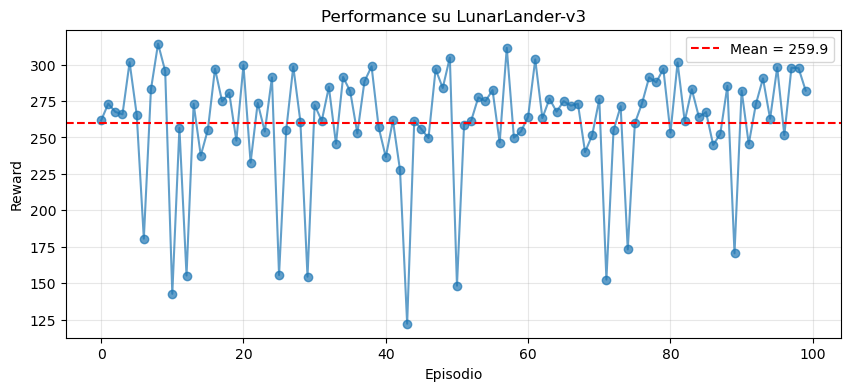

{'rewards': [261.63312841283323,
  273.1463213083917,
  267.5103162484798,
  265.84376975507655,
  301.57969006776847,
  265.6056852596482,
  180.53046107721227,
  282.95306992681697,
  314.29622959308983,
  295.56000397354467,
  142.69003874227576,
  256.46975113961906,
  155.22430445825216,
  272.9797452111118,
  237.54034733944212,
  255.35159846726364,
  297.12270970620534,
  274.6700669450529,
  280.64420210530386,
  247.80889974587976,
  299.5528464206409,
  232.69770907453105,
  273.6486863808435,
  254.0088054438839,
  291.13869010931074,
  155.57907071031156,
  254.7716777962712,
  298.5881450266014,
  260.8608235891836,
  154.43704223538356,
  272.16800875428646,
  261.37884092446006,
  284.55366224390696,
  245.65170377538345,
  291.45312496567465,
  281.58314449063374,
  252.76122723464715,
  288.3799706421935,
  298.7505893167506,
  256.8322585281359,
  236.50233283229832,
  261.69791426952986,
  227.5167983883894,
  122.17034575909389,
  261.5597957797737,
  255.658834117

In [3]:
import Test_model
Test_model.test_model(
        path_model="Reinforcement_Learning_CartLunar/cartpole/run_04_12_25T15_48/best_model.pth",
        env_test="CartPole-v1",
        num_episode=50,
        render=False
    )
Test_model.test_model(
        path_model="Reinforcement_Learning_CartLunar/lunars/run_06_12_25T16_11/best_model.pth",
        env_test="LunarLander-v3",
        num_episode=100,
        render=False,
        name_key="lunars"
    )

## Risultati TEST
Todo